In [1]:
from func import DataProcessor,TipFinder,VertexPos
import seaborn as sns
import numpy as np
import pylab as plt
import pandas as pd
from scipy import stats
import cv2
import time
import re
import math
from sklearn import mixture
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from sklearn import linear_model

%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 20)

In [2]:
dp = DataProcessor('../../data/SQL/10C/85_8.db','../../data/SQL/10C/ProtoMap.db')

initialization will take some time
140.910966873
   PadNum        PadName     PadX      PadY  BinNum
0       0  sector_center  0.00000  0.000000     257
1       1      sector1_0  1.30108  0.947523       1
2       2      sector2_0  2.18496  1.831410       2
3       3      sector1_1  2.71529  2.361740       3
4       4      sector2_1  3.59917  3.245620       4
loading finished
begin processing
15.6622641087
30.8966369629
processing finished


In [88]:
EID=31
t3 = dp.t3

tmp = t3[(t3['EventID']==EID)&(t3['charge']>3)].copy()
p = (tmp['PadNum']-1)%63+1

tmp['PadPos'] = ((p-9)*(p>9)+p)*(tmp['PadNum']!=0)

Q = [tmp[(tmp['PadX']>0)&(tmp['PadY']>0)] ,tmp[(tmp['PadX']<0)&(tmp['PadY']>0)],
    tmp[(tmp['PadX']<0)&(tmp['PadY']<0)], tmp[(tmp['PadX']>0)&(tmp['PadY']<0)]]


image1 = np.zeros([300,600])

image1[(-Q[0]['PadPos'].values+151).astype(np.int), Q[0]['time'].values.astype(np.int)] =255
image1[(Q[2]['PadPos'].values+150).astype(np.int), Q[2]['time'].values.astype(np.int)] =255

image2 = np.zeros([300,600])

image2[(-Q[1]['PadPos'].values+151).astype(np.int), Q[1]['time'].values.astype(np.int)] =255
image2[(Q[3]['PadPos'].values+150).astype(np.int), Q[3]['time'].values.astype(np.int)] =255


width,height = 300,600
a = np.concatenate([np.arange(width/2,0,-1),np.arange(1,width/2+1,1)])
weights = np.tile(a,height).reshape(height,width).T/150.0

image1[:50,:] = 0
image2[:50,:] = 0

image1[-50:,:] = 0
image2[-50:,:] = 0



if np.sum(image1*image2*weights**4)>np.sum(image1*image2[::-1]*weights**4):
    image = image1+image2#[::-1]
else:
    image = image1+image2[::-1]

    
image = np.where(image>100,255,0).astype(np.uint8)

gray = cv2.GaussianBlur(image, (3, 3), 0)
ret,im = cv2.threshold(gray.astype(np.uint8), 10, 255, cv2.THRESH_BINARY)

thresh = im.astype(np.uint8)
for _ in range(3):
    thresh = cv2.erode(thresh, None, iterations=1)
    thresh = cv2.dilate(thresh, None, iterations=1)
image = thresh

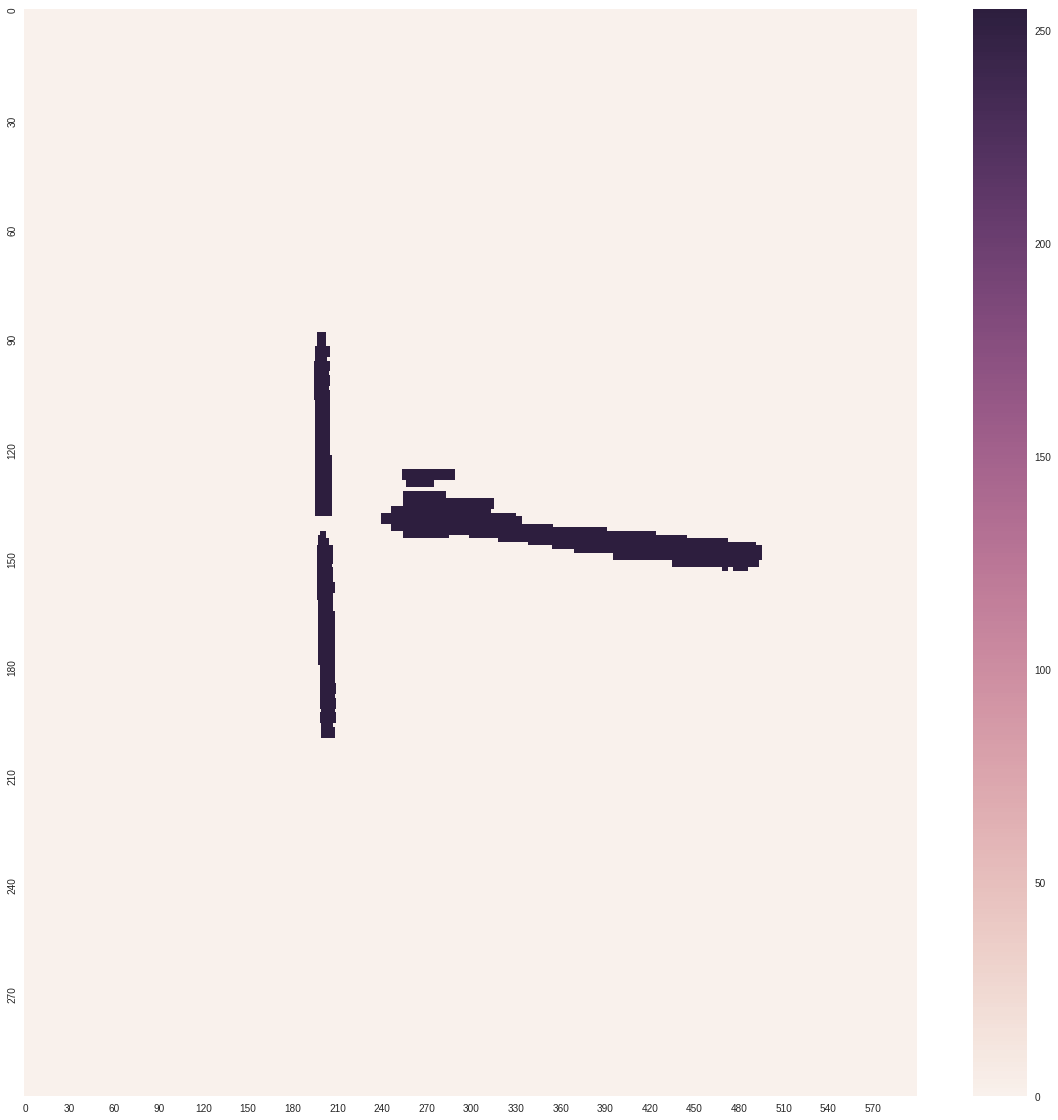

In [89]:
sns.heatmap(image, xticklabels=30, yticklabels=30)
#y,x = np.where(image1)
#plt.scatter(x,y,c='b')
#y,x = np.where(image2)
#plt.scatter(x,y,c='r')


In [90]:
#pic, images = dp.Process1(9)

In [91]:
def Distance(contours,n1,n2):

    c1,c2 = contours[n1], contours[n2]

    c1,c2 = c1[:,0,:],c2[:,0,:]

    m1 = np.repeat([c1],c2.shape[0],axis=0)
    m2 = np.repeat([c2],c1.shape[0],axis=0)
    t2 = np.transpose(m2,axes=(1,0,2))
    diff = np.sqrt(np.sum(np.power(m1-t2,2),axis=2))

    return np.min(diff)

def Groups(contours):
    r,a = [],[]
    ## breadth first search
    pool = range(len(contours))
    area = 0
    while pool:
        seen = set([pool[0]])
        ans = set([pool[0]])
        sea = set([pool[0]])
        area = cv2.contourArea(contours[pool[0]])


        while sea:
            nsea = set([])

            for c in sea:
                for n in pool:
                    if n not in seen and Distance(contours,c,n)<40:
                        #print Distance(c,n),Distance(c,n)<8
                        area += cv2.contourArea(contours[n])
                        ans.add(n)
                        nsea.add(n)
                        seen.add(n)
            sea = nsea

        pool = [_ for _ in pool if _ not in ans]


        #print pool
        a.append(area)
        r.append(ans)

    r = [[contours[__] for __ in _] for _ in r]

    return zip(*[(x,y) for x,y in zip(r,a) if y>500])

def convexHull(thresh, debug_mode = 0):

    thresh = np.copy(thresh)
    if debug_mode: sns.heatmap(thresh[::-1], xticklabels=30, yticklabels=30)

    m1, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    
    gpc,gpa = Groups(contours)
    gpc = [np.concatenate(g,axis=0) for g in gpc]
    
    if debug_mode: plt.scatter(gpc[0][:,0,0],gpc[0][:,0,1])
    
    cnt = gpc[np.argmax(gpa)]
    hull = cv2.convexHull(cnt)
    
    if debug_mode: plt.plot(hull[:,0,0],hull[:,0,1],c='r')
    
    return hull#[:,0,:]


def MaxEnclosedTriangle(hull):
    def area(*i):
        a,b,c= hull[i,0]
        return np.abs(np.cross(b-c,c-a))

    A = 0;B = 1; C = 2; n=hull.shape[0]
    bA= A; bB= B; bC= C #The "best" triple of points
    while True: #loop A
        while True: #loop B
            while area(A, B, C) <= area(A, B, (C+1)%n): #loop C
                C = (C+1)%n
            if area(A, B, C) <= area(A, (B+1)%n, C): 
                B = (B+1)%n
                continue
            else:
                break

        if area(A, B, C) > area(bA, bB, bC):
            bA = A; bB = B; bC = C

        A = (A+1)%n
        if A==B: B = (B+1)%n
        if B==C: C = (C+1)%n
        if A==0: break
    
    return bA,bB,bC
    
def TipFinder(thresh, debug_mode = 0):

    hull = convexHull(thresh, debug_mode)
        
    #############################
    bA,bB,bC = MaxEnclosedTriangle(hull)

    if debug_mode: plt.scatter(hull[[bA,bB,bC],0,0],hull[[bA,bB,bC],0,1],marker='*', s=500,c='g')
    
    return hull[[bA,bB,bC],0]

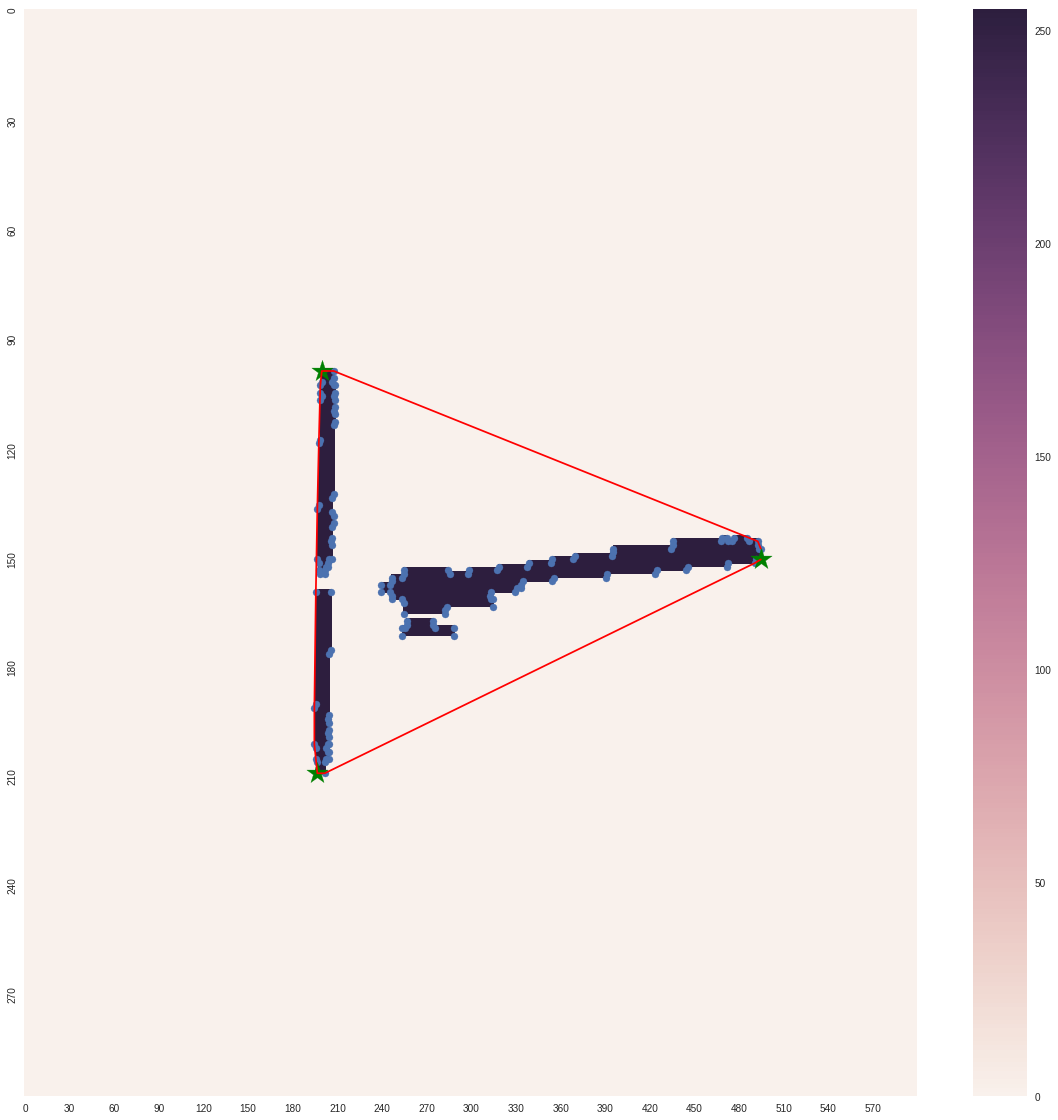

In [92]:
points = TipFinder(image.astype(np.uint8),debug_mode=1)
#xv,yv = points[points[:,0].argsort()][-1]

#thresh = np.copy(image)
#sns.heatmap(thresh[::-1], xticklabels=30, yticklabels=30)

#m1, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


#print contours

(0, 300)

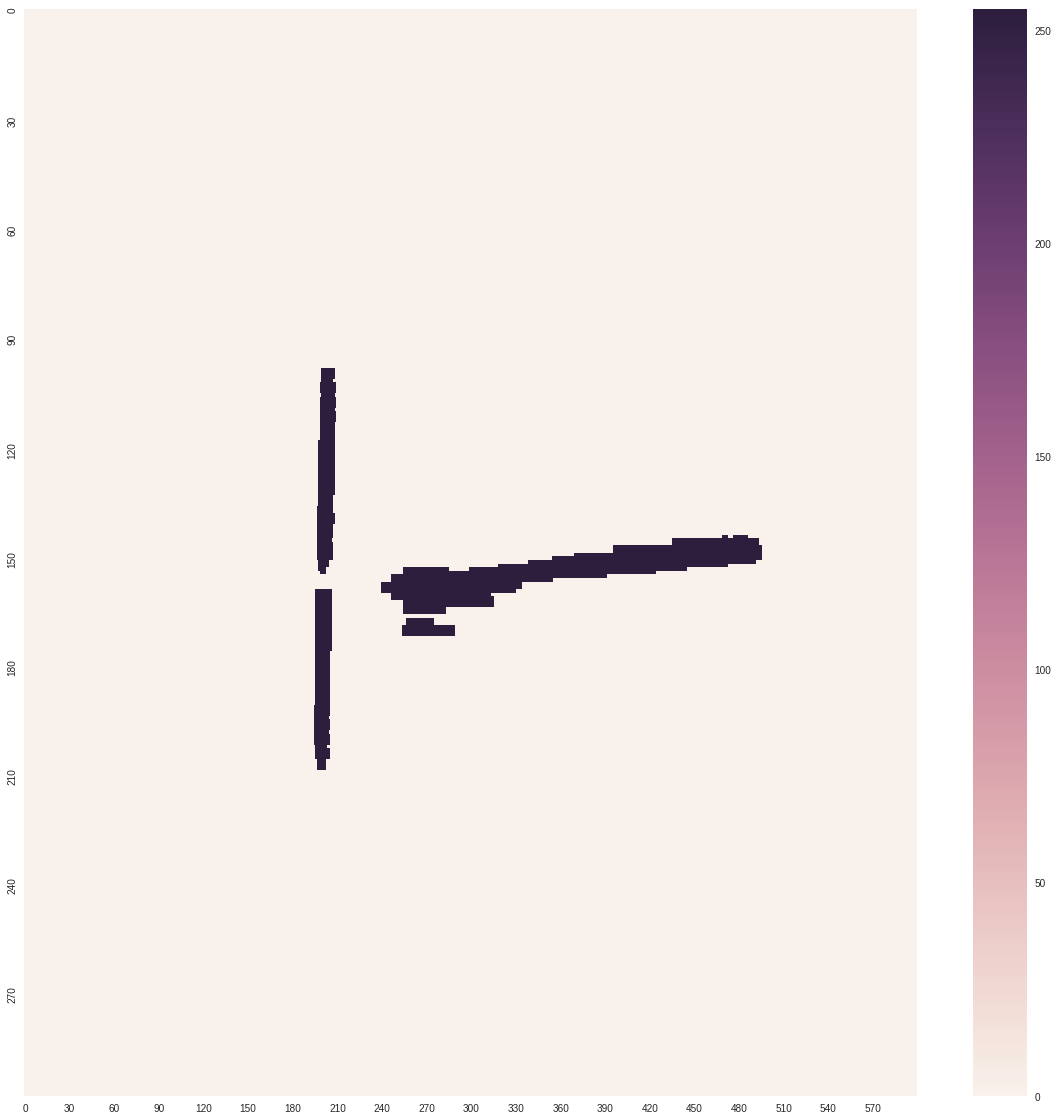

In [93]:

def FilterBackground(image):
    hull = convexHull(image, debug_mode = False)

    ys,xs = np.where(image)
    path1 = mplPath.Path(hull[:,0,:])
    patch = patches.PathPatch(path1, facecolor=(0,0,0,0),EdgeColor='r', lw=2)
    mask = path1.contains_points(zip(xs,ys))
    image_ = np.zeros(image.shape)
    image_[ys[mask],xs[mask]] = 255
    
    return image_

    

image_ = FilterBackground(image)
sns.heatmap(image_[::-1], xticklabels=30, yticklabels=30)
    
plt.xlim([0,600])
plt.ylim([0,300])



In [94]:
def tbjcfit(xs,ys):
    xc,yc = xs.mean(),ys.mean()
    u,s,v = np.linalg.svd(np.array([xs-xc,ys-yc]).T)
    xi,yi = v[0]
    k = yi/(xi+1e-9*abs(xi)/xi)
    b = yc-k*xc
    return k,b


def AveDist(x,y,k,b):
    return np.sum(np.abs(k*x+b-y)/(k*k+1))/x.shape[0]

def r2(x,y,k,b):
    return 1-np.sum(((x*k+b)-y)**2)/np.sum((y-np.mean(y))**2)

def VertexPos(fits,y0):
    print 'lalal', fits
    fits = [f for f in fits if f[0]>60 and f[-1]<2.5]
    
    num_lines = len(fits)
    
    if num_lines == 0: raise Exception('This is probably an unreacted beam')
    fits = fits[:1]+[f for f in fits[1:] if abs(f[1]-fits[0][1])/(abs(fits[0][1])+1e-9)>0.5]
    k1,b1 = fits[0][1:3]
    
    print 'lalal', fits
    num_lines = len(fits)
    
    if num_lines==1:
        return (y0-b1)/k1,y0
    else:
        k2,b2 = fits[1][1:3]
        return (b2-b1)/(k1-k2), (k2*b1-k1*b2)/(k2-k1)
        

        
def GetFit(image_, part_thresh=60, err_thresh =1.2,spread_thresh=6):        

    print np.sum(image_>10)
    if np.sum(image_>10) > part_thresh:
        ys,xs = np.where(image_)

        plt.scatter(xs,ys,c='r')
        
        k,b = tbjcfit(xs,ys)
        print 'fit',AveDist(xs,ys,k,b),k,b,np.std(xs), np.std(ys)
        print AveDist(xs,ys,k,b)<err_thresh  and (np.std(xs)>spread_thresh or np.std(ys)>spread_thresh)

        
        
        try:

            k,b = tbjcfit(xs,ys)
            #print 'fit',AveDist(xs,ys,k,b),k,b,np.std(xs), np.std(ys)
            #print AveDist(xs,ys,k,b)<err_thresh  and (np.std(xs)>spread_thresh or np.std(ys)>spread_thresh)
            if AveDist(xs,ys,k,b)<err_thresh and (np.std(xs)>spread_thresh or np.std(ys)>spread_thresh):

                return (np.sum(image_>10),k,b,AveDist(xs,ys,k,b))
            else:
                return (0,0,0,100)
        except:
            return (0,0,0,100)

    else:
        return (0,0,0,100)
    
   
    
    
        
def GetRange(pic,debug_mode=0, center_width = 12, quadrant_thresh=100, center_thresh=300, 
             err_thresh =3, spread_thresh=6 ):
    pic_ = np.copy(pic).astype(np.uint8)

    points = TipFinder(pic_,debug_mode)
    xv,yv = points[points[:,0].argsort()][-1]
    
    #### get fit from each of the quadrant ###
    fits = []
    for idx in range(2):
        image_ = np.copy(pic_)
        if idx:
            image_[int(yv)-center_width:,:] = 0
        else:
            image_[:int(yv)+center_width,:] = 0
        
        fits.append(GetFit(cv2.erode(image_, None, iterations=1),
                    quadrant_thresh,err_thresh,spread_thresh))
    #plt.clf()
    #plt.cla()
    #print 'here'
    #sns.heatmap(image_[::-1], xticklabels=30, yticklabels=30)

    #print GetFit(image_, quadrant_thresh,err_thresh,spread_thresh)
    #print 'hereherehere'
    #return
    print '###########################'
    ##### get the fitting from the center line ####
    fit = fits[0] if fits[0][0]>quadrant_thresh and fits[0][-1]<err_thresh else fits[1]
    if fit[0]>quadrant_thresh and fit[-1]<err_thresh:
        y_,x_ = (150-fit[2])/fit[1],150
        image_ = np.copy(pic_)
        image_[:,:int(y_)+10] = 0  
        #sns.heatmap(cv2.erode(image_, None, iterations=1)[::-1], xticklabels=30, yticklabels=30)
        fits.append(GetFit(cv2.erode(image_, None, iterations=1),
                           center_thresh,err_thresh,spread_thresh))

    else:
        fits.append((0,0,0,100))
    
    #print fits
    #return
    ### process the fits according to each of the scenario
    xc,yc = VertexPos(fits,yv)
    #print xc,yc
    
    if debug_mode:
        for s_,k_,b_,err_ in fits: 
            if s_>60 and err_<3: plt.plot(np.linspace(0,600,2),b_+k_*np.linspace(0,600,2))
        plt.scatter([xc],[yc],marker='o',s=300,c='g')
    
    return ((xc-xv)**2+(yc-yv)**2)**0.5


319
fit 0.090093312222 22.8787712947 -4470.51254099 2.43753740983 10.9588746233
True
443
fit 8.36530468102 0.276820310382 57.8901332504 28.421115301 12.8623607189
False
###########################
1611
fit 2.23767206469 0.0620612863649 121.481248537 75.7026038759 5.57417600876
True
lalal [(319, 22.878771294685045, -4470.5125409937955, 0.090093312221958502), (0, 0, 0, 100), (1611, 0.062061286364940044, 121.48124853716034, 2.2376720646927577)]
lalal [(319, 22.878771294685045, -4470.5125409937955, 0.090093312221958502), (1611, 0.062061286364940044, 121.48124853716034, 2.2376720646927577)]
294.079058352


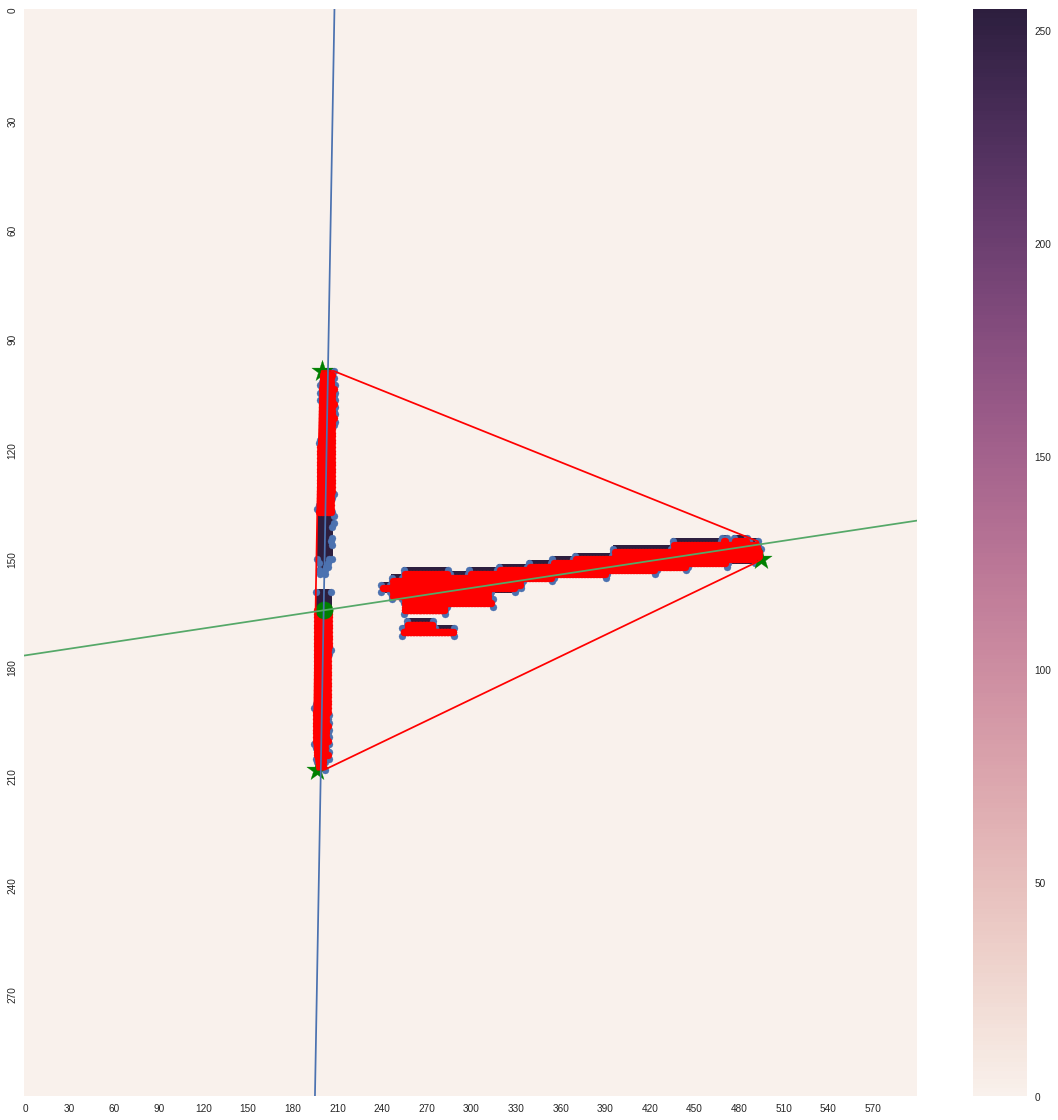

In [95]:

#pic, images = dp.Process1(9)
#sns.heatmap(pic[::-1], xticklabels=30, yticklabels=30)
print GetRange(image_,1)

In [ ]:
center_width = 12
quadrant_thresh=100
center_thresh=800
err_thresh =2
spread_thresh=6
pic_ = np.copy(image)

points = TipFinder(pic_,0)
xv,yv = points[points[:,0].argsort()][-1]

#### get fit from each of the quadrant ###
fits = []
for idx in range(2)[:1]:
    image_ = np.copy(pic_)
    if idx:
        image_[int(yv)-center_width:,:] = 0
    else:
        image_[:int(yv)+center_width,:] = 0

    fits.append(GetFit(cv2.erode(image_, None, iterations=1),
                quadrant_thresh,err_thresh,spread_thresh))

#sns.heatmap(image_[::-1], xticklabels=30, yticklabels=30)

#print GetFit(GetFit(cv2.erode(image_, None, iterations=1),
#                quadrant_thresh,err_thresh,spread_thresh))

    

plt.clf()
plt.cla()

ys,xs = np.where(image_)


#k,b = np.polyfit(xs,ys,1)f

k,b = tbjcfit(xs,ys)
plt.scatter(xs,ys,c='r')

plt.plot(np.linspace(0,600,2),b+k*np.linspace(0,600,2))
print 'fit',AveDist(xs,ys,k,b),k,b
print np.std(xs), np.std(ys)
#if AveDist(xs,ys,k,b)<err_thresh and (np.std(xs)>spread_thresh or np.std(ys)>spread_thresh):
#    return (np.sum(image_>10),k,b,AveDist(xs,ys,k,b))

plt.ylim(0,300)
plt.xlim(0,600)
    

In [ ]:
ys,xs = np.where(image_)
xc,yc = xs.mean(),ys.mean()
#xs = xs-xc
#ys = ys-yc
plt.scatter(xs,ys)
plt.ylim(-300,300)
plt.xlim(0,600)
u,s,v = np.linalg.svd(np.array([xs-xc,ys-yc]).T)

In [ ]:
print v

In [ ]:

plt.scatter(xs,ys)


xi,yi = v[0]
print xi,yi
k = yi/(xi+1e-9*abs(xi)/xi)
b = yc-k*xc
print k,b

plt.plot(np.arange(0,600,2),k*np.arange(0,600,2)+b)
plt.ylim(0,600)
plt.xlim(0,300)

In [ ]:
ys = np.linspace(0,300,600)
xs = np.random.rand(600)+100

In [ ]:
plt.scatter(xs,ys)
plt.xlim([0,600])
plt.ylim([0,300])

k,b =  tbjcfit(xs,ys)

plt.plot(np.sort(xs),k*np.sort(xs)+b,c='r')

In [19]:
import matplotlib.path as mplPath
import matplotlib.patches as patches
